In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import zipfile

from tensorflow.keras import mixed_precision
import splitfolders
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
splitfolders.ratio('/content/drive/MyDrive/corn_disease_project/Corn-disease-classification/training/data', output="/content/drive/MyDrive/J_comp_Neural_network/dataset/data", seed = 48, ratio=(.8,0.15,0.05)) 

Copying files: 4188 files [02:55, 23.90 files/s]


In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/J_comp_Neural_network/dataset_1/train.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
for dirnames,dirpath,filenames in os.walk("train"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
image_size = 256
channels = 3
epochs = 50

In [ ]:
train_d = ImageDataGenerator(
        rescale=1./255,
        shear_range = 0.2,
        zoom_range = 0.4,

)

train_generator = train_d.flow_from_directory(
        '/content/drive/MyDrive/J_comp_Neural_network/dataset/data/train',
        target_size=(image_size,image_size),
        batch_size=16,
        class_mode="categorical",

        #save_to_dir = "/content/drive/MyDrive/J_comp_Neural_network/dataset/augmented_images"

)

Found 3348 images belonging to 4 classes.


In [ ]:
valid_d = ImageDataGenerator(
        rescale = 1./255,
        shear_range = 0.2,
        zoom_range = 0.4,

)

valid_generator = valid_d.flow_from_directory(
        '/content/drive/MyDrive/J_comp_Neural_network/dataset/data/val',
        target_size=(image_size,image_size),
        batch_size=16,
        class_mode="categorical",
)

Found 626 images belonging to 4 classes.


In [ ]:
test_d = ImageDataGenerator(
        rescale = 1./255,
        shear_range = 0.2,
        zoom_range = 0.4,

)

test_generator = test_d.flow_from_directory(
        '/content/drive/MyDrive/J_comp_Neural_network/dataset/data/test',
        target_size=(image_size,image_size),
        batch_size=16,
        class_mode="categorical",
)

Found 214 images belonging to 4 classes.


In [ ]:
input_shape = (image_size,image_size,channels)
classes = 5

In [ ]:
from keras.layers.convolutional import UpSampling2D
image_shape = (image_size,image_size,channels)
image = Input(shape=image_shape)


x = Conv2D(64, (3, 3), activation='relu',padding='same', dilation_rate=(2, 2), name='block1_conv1')(image)
x = MaxPooling2D((2,2),padding = 'same')(x)
x = Conv2D(32,(3,3),activation = 'relu',padding = 'same',dilation_rate=(2, 2))(x)
x = MaxPooling2D((2,2),padding = 'same')(x)
x = Conv2D(16,(3,3),activation = 'relu',padding = 'same',dilation_rate=(2, 2))(x)
x = MaxPooling2D((2,2),padding = 'same')(x)

x = Conv2D(16,(3,3),activation = 'relu',padding = 'same',dilation_rate=(2, 2))(x)
x = UpSampling2D((2,2))(x)

x = Conv2D(32,(3,3),activation = 'relu',padding = 'same',dilation_rate=(2, 2))(x)
x = UpSampling2D((2,2))(x)

x = Conv2D(64,(3,3),activation = 'relu',padding = 'same',dilation_rate=(2, 2))(x)
x = UpSampling2D((2,2))(x)

#x = Flatten()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation = 'relu')(x)
x = Dense(256,activation = 'relu')(x)
x = Dense(512,activation = 'relu')(x)
x = Dense(5,activation = 'softmax')(x)


model = Model(inputs = image, outputs = x)
model.compile(optimizer= 'adam' , loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 64)     0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      4624  

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss',patience = 3,verbose = 1)
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [early_stop]

In [ ]:
history_1 = model.fit(
    
    train_generator,
    steps_per_epoch = 49,
    batch_size = 32,
    validation_data = valid_generator,
    validation_steps = 20,
    verbose = 1,
    epochs = 50,
)

In [ ]:
model.evaluate(test_generator)

36/36 [==============================] - 437s 12s/step - loss: 1.0046 - accuracy: 0.6322


[1.0046132802963257, 0.6322241425514221]

In [ ]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

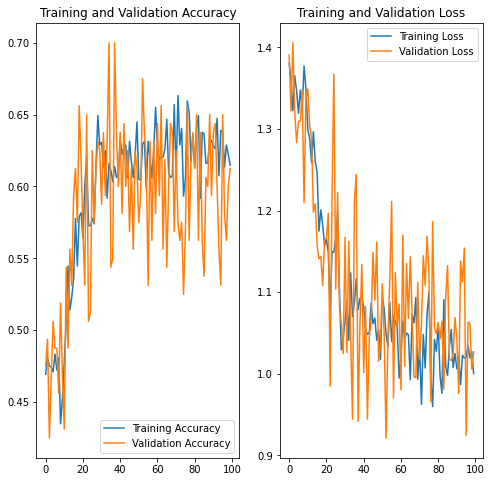

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(100), acc, label='Training Accuracy')
plt.plot(range(100), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(100), loss, label='Training Loss')
plt.plot(range(100), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
history_2 = model.fit(
    
    train_generator,
    steps_per_epoch = 49,
    batch_size = 32,
    validation_data = valid_generator,
    validation_steps = 11,
    verbose = 1,
    epochs = 100,
    callbacks = callbacks_list
)

# **Parallel convolution model**

In [ ]:
from keras.layers.convolutional import UpSampling2D
image_shape = (image_size,image_size,channels)
image = Input(shape=image_shape)

input_shape = image_shape
classes = 5

In [ ]:
from keras.layers.pooling import MaxPooling3D
from keras.layers.pooling import AveragePooling2D
#image_1 = layers.experimental.preprocessing.Resizing(128, 128)(image)
x1=  Conv2D(64, (3, 3),strides = (1,1), activation='relu',padding='same',kernel_initializer='he_uniform',name = 'conv2d_1')(image)

x2 = Conv2D(64,(3,3),activation = 'relu',strides = (1,1),padding  = 'same',kernel_initializer='he_uniform',name = 'conv2d_2')(image)

x3 = Conv2D(256,(3,3),activation = 'relu',strides = (1,1), padding  = 'same',kernel_initializer='he_uniform',name = 'conv2d_3')(image)
p1 = AveragePooling2D((2,2))(x1)
p2 = AveragePooling2D((2,2))(x2)
p3 = AveragePooling2D((2,2))(x3)

c1 = layers.concatenate([p1,p2,p3])

#c2 = Flatten()(c1)
c1_batch = BatchNormalization()(c1)
#c1_glob = GlobalAveragePooling2D()(c1_batch)
#c1_dense = Dense(16,activation = 'relu',kernel_initializer='he_uniform')(c_glob)
c2_dense = Dense(128,activation = 'relu',kernel_initializer='he_uniform')(c1_batch)

#max_out = MaxPooling2D((2,2))(c2_dense)

max_out = Flatten()(c2_dense)
out = Dense(4,activation = 'softmax',kernel_initializer='he_uniform')(max_out)


#p_model = Model(inputs = image, outputs = out)
p_model_1 = Model(inputs = image, outputs = out)
p_model_1.compile(optimizer= 'adam' , loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False), metrics=['accuracy'])

In [ ]:

p_model_1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                           

In [ ]:

early_stop = EarlyStopping(monitor = 'val_loss',patience = 7,verbose = 1)
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [early_stop]

In [35]:
history_9 = p_model_1.fit(
    
    train_generator,
    steps_per_epoch = 49,
    validation_data = valid_generator,
    validation_steps =12,
    verbose = 1,
    epochs = 50,
    callbacks = callbacks_list
)

Epoch 1/50
49/49 [==============================] - 381s 8s/step - loss: 76.3419 - accuracy: 0.6801 - val_loss: 130.8481 - val_accuracy: 0.3333
Epoch 2/50
49/49 [==============================] - 378s 8s/step - loss: 16.0513 - accuracy: 0.7876 - val_loss: 16.8004 - val_accuracy: 0.5625
Epoch 3/50
49/49 [==============================] - 377s 8s/step - loss: 16.7119 - accuracy: 0.7806 - val_loss: 15.3669 - val_accuracy: 0.6354
Epoch 4/50
49/49 [==============================] - 387s 8s/step - loss: 7.9675 - accuracy: 0.7870 - val_loss: 4.6522 - val_accuracy: 0.7396
Epoch 5/50
49/49 [==============================] - 388s 8s/step - loss: 3.4286 - accuracy: 0.8469 - val_loss: 1.8883 - val_accuracy: 0.7604
Epoch 6/50
49/49 [==============================] - 379s 8s/step - loss: 2.3782 - accuracy: 0.8316 - val_loss: 1.8058 - val_accuracy: 0.8229
Epoch 7/50
49/49 [==============================] - 381s 8s/step - loss: 1.3488 - accuracy: 0.8342 - val_loss: 4.9088 - val_accuracy: 0.5469
Epoch 

In [36]:
test_scores = p_model_1.evaluate(test_generator)

14/14 [==============================] - 32s 2s/step - loss: 0.5590 - accuracy: 0.8505


In [37]:
acc_2 = history_9.history['accuracy']
val_acc_2 = history_9.history['val_accuracy']

loss_2 = history_9.history['loss']
val_loss_2 = history_9.history['val_loss']

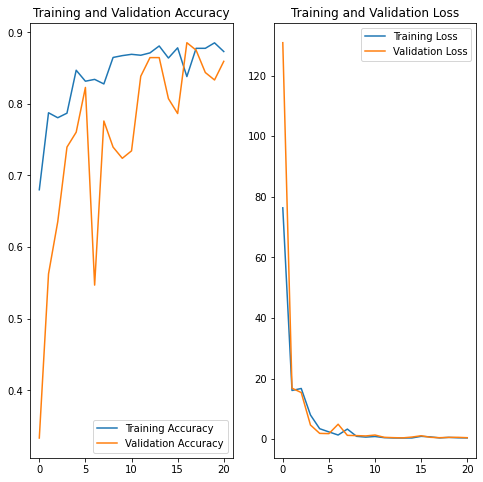

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(21), acc_2, label='Training Accuracy')
plt.plot(range(21), val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(21), loss_2, label='Training Loss')
plt.plot(range(21), val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
acc_1 = history_4.history['accuracy']
val_acc_1 = history_4.history['val_accuracy']

loss_1 = history_4.history['loss']
val_loss_1 = history_4.history['val_loss']

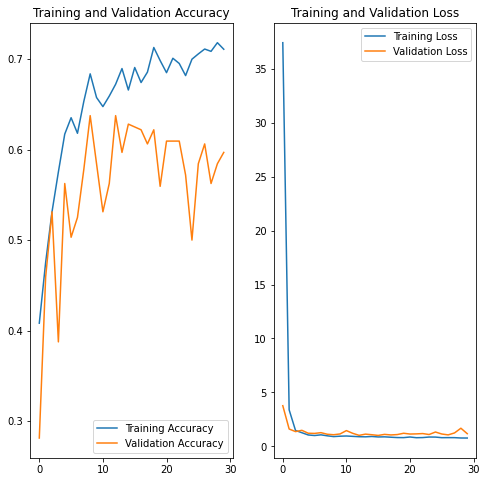

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(30), acc_1, label='Training Accuracy')
plt.plot(range(30), val_acc_1, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(30), loss_1, label='Training Loss')
plt.plot(range(30), val_loss_1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
p_model.save("/content/drive/MyDrive/J_comp_Neural_network/dataset_1")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/J_comp_Neural_network/dataset_1/assets


In [ ]:
history_5 = p_model_1.fit(
    
    train_generator,
    steps_per_epoch = 45,
    validation_data = valid_generator,
    validation_steps =10,
    verbose = 1,
    epochs = 45,
)

Epoch 1/45
45/45 [==============================] - 45s 987ms/step - loss: 121.2653 - accuracy: 0.3806 - val_loss: 1.8589 - val_accuracy: 0.1187
Epoch 2/45
45/45 [==============================] - 43s 947ms/step - loss: 1.5300 - accuracy: 0.4375 - val_loss: 1.5733 - val_accuracy: 0.5063
Epoch 3/45
45/45 [==============================] - 41s 908ms/step - loss: 1.3258 - accuracy: 0.5155 - val_loss: 1.5591 - val_accuracy: 0.4281
Epoch 4/45
45/45 [==============================] - 41s 921ms/step - loss: 1.2847 - accuracy: 0.4986 - val_loss: 1.5177 - val_accuracy: 0.5188
Epoch 5/45
45/45 [==============================] - 44s 987ms/step - loss: 1.2533 - accuracy: 0.5493 - val_loss: 1.5315 - val_accuracy: 0.4531
Epoch 6/45
45/45 [==============================] - 41s 920ms/step - loss: 1.2510 - accuracy: 0.5111 - val_loss: 1.5116 - val_accuracy: 0.4094
Epoch 7/45
45/45 [==============================] - 42s 927ms/step - loss: 1.2599 - accuracy: 0.5083 - val_loss: 1.4005 - val_accuracy: 0.50